# Quantium Data Analytics Virtual Experience Program
## Task 1: Data preparation and customer analytics
In this notebook, I explore two datasets: transactional data and customer behaviour data.
- Transaction Data - Cleaning
- Transaction Data - Visualization
- Customer Data - Cleaning
- Customer Data - Visualization
- Customer Segment Analysis
- Target Segment - Basket Analysis
- Conclusion

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import ttest_ind, t
pd.options.mode.chained_assignment = None

## Transaction Data - Cleaning
### Read in the dataset and check simple information

In [2]:
# Read in the dataset
trans = pd.read_excel('QVI_transaction_data.xlsx')

In [3]:
# Check first 5 rows
trans.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
# Change column headers to lower cases and rename columns
trans.columns = map(str.lower, trans.columns)
trans = trans.rename(columns={'lylty_card_nbr':'card_nbr'})

In [5]:
# Check general info
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       264836 non-null  int64  
 1   store_nbr  264836 non-null  int64  
 2   card_nbr   264836 non-null  int64  
 3   txn_id     264836 non-null  int64  
 4   prod_nbr   264836 non-null  int64  
 5   prod_name  264836 non-null  object 
 6   prod_qty   264836 non-null  int64  
 7   tot_sales  264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


### Change data types

In [6]:
# Convert Excel dates to dates
import datetime
import xlrd
date_tuple = [xlrd.xldate.xldate_as_datetime(x, 0)
              for x in trans['date'].tolist()]
trans['date'] = [d.strftime('%m-%d-%Y') for d in date_tuple]
trans['date'] = pd.to_datetime(trans['date'])

In [7]:
# Change id variables to categorical values
obj_type = ['store_nbr','card_nbr','txn_id','prod_nbr']
trans[obj_type] = trans[obj_type].astype(str)

# Create price column
trans['prod_price'] = trans['tot_sales']/trans['prod_qty']

### Check simple statistics and clean data
**Numerical variables**

In [8]:
# Numerical data
trans.describe()

,prod_qty,tot_sales,prod_price
count,264836.000000,264836.000000,264836.000000
mean,1.907309,7.304200,3.824624
std,0.643654,3.083226,1.109523
min,1.000000,1.500000,1.320000
25%,2.000000,5.400000,3.000000
50%,2.000000,7.400000,3.800000
75%,2.000000,9.200000,4.600000
max,200.000000,650.000000,6.500000


We seem to have outliers of product quantity and total sales. Let's draw box plots of these variables.

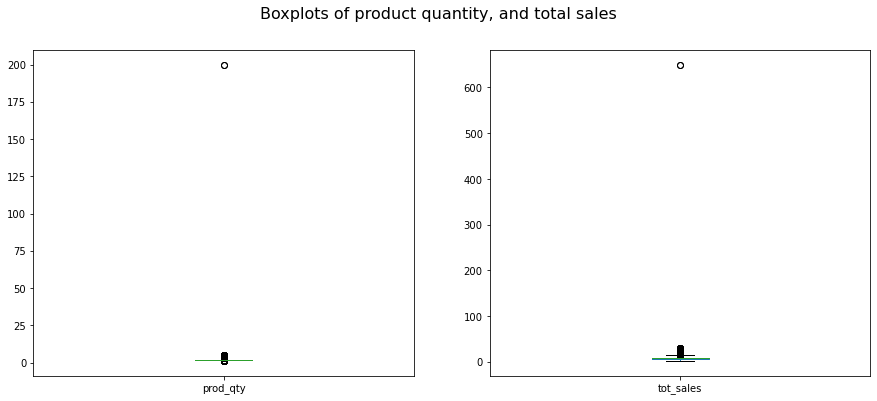

In [9]:
# Draw boxplots
fig, axes = plt.subplots(1,2, figsize=(15,6))
trans.plot.box(y='prod_qty', ax=axes[0])
trans.plot.box(y='tot_sales', ax=axes[1])
fig.suptitle('Boxplots of product quantity and total sales', fontsize=16)
plt.show()

In [10]:
# Check which rows have product quantity of 100 and above
trans[trans['prod_qty'] > 100][['card_nbr','prod_qty','tot_sales']]

,card_nbr,prod_qty,tot_sales
69762,226000,200,650.0
69763,226000,200,650.0


There're only two records from one customer (same card_nbr) so I will remove these outliers.

In [11]:
# Doulbe ckeck these rows before removing them
trans[trans['card_nbr'] == '226000']

,date,store_nbr,card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,prod_price
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,3.25
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,3.25


In [12]:
# Keep rows that have product quantity that is less than 100
trans = trans[trans['prod_qty'] < 100]

In [13]:
# Check maximum values of prod_qty and tot_sales
trans[['prod_qty','tot_sales']].max()

prod_qty      5.0
tot_sales    29.5
dtype: float64

**Datetime variables**

In [14]:
# Check datetime values
trans.describe(include=np.datetime64)

,date
count,264834
unique,364
top,2018-12-24 00:00:00
freq,939
first,2018-07-01 00:00:00
last,2019-06-30 00:00:00


We have 364 unique dates instead of 365. Let's see which date is missing.

In [15]:
# Create list of date from 07/01/2018 to 06/30/2019
date_range = pd.DataFrame(pd.date_range('2018-07-01', '2019-06-30').tolist(),
                          columns=['date'])

# Merge this list to column date, showing indicator
date_merge = pd.merge(trans['date'],
                      date_range,
                      on='date',
                      how='outer',
                      indicator=True)

# Row that has indicator (_merge column) as right_only contains the missing date
date_merge[date_merge['_merge'] == 'right_only']

,date,_merge
264834,2018-12-25,right_only


All stores seem to close on Christmas, so we don't have any transaction data on that date.

From date data, I also want to extract year, month, and weekday information.

In [16]:
# Create new columns for year, month, and weekday
trans['year'], trans['month'], trans['weekday'] = \
trans['date'].dt.year, trans['date'].dt.month, trans['date'].dt.day_name()

**Categorical variables**

In [17]:
# Check categorical values
trans.describe(include=object)

,store_nbr,card_nbr,txn_id,prod_nbr,prod_name,weekday
count,264834,264834,264834,264834,264834,264834
unique,272,72636,263125,114,114,7
top,226,172032,1162,102,Kettle Mozzarella Basil & Pesto 175g,Sunday
freq,2020,18,3,3304,3304,38717


Noticing the number of unique customers (card_nbr) and transactions (txn_id), we can see that one customer can have multiple transactions. However, one customer should have one transaction on the same date, in the same store at a time. I would like to make sure we don't have any duplicated transaction in any way.

**Remove duplicates**

In [18]:
# Drop duplicates if available
trans = trans.drop_duplicates(ignore_index=True)

# Print data length
print(f'There are {len(trans)} unique data rows.')

There are 264833 unique data rows.


In [19]:
# Check how many rows that have the same information of date, store_nbr, card_nbr, and txn_id
print(f"There are {trans.duplicated(['date','store_nbr','card_nbr','txn_id']).sum()} \
rows that have the same information of date, store number, customer, and transaction id.")

There are 1704 rows that have the same information of date, store number, customer, and transaction id.


This does not seem right. Let's group our data by transaction id and count unique values of other columns.

In [20]:
# Create dataframe including date, store_nbr, card_nbr, txn_id, and prod_nbr that have same txn_id
dup_trans = trans[trans.duplicated('txn_id', keep=False)][['date','store_nbr','card_nbr','txn_id','prod_nbr']]

# Group this dataframe by txn_id, counting number of unique values of other columns
count_df = dup_trans.groupby(['txn_id']).nunique()

Now let's print out data that have more than one unique value of date, store_nbr, or card_nbr. If a txn_id has more than one unique value of any of these columns, then that transaction is duplicated.

In [21]:
# Print out data that have more than one unique value of date, store_nbr, or card_nbr
count_df[(count_df['date'] != 1) |
         (count_df['store_nbr'] != 1) |
         (count_df['card_nbr'] != 1)]

,date,store_nbr,card_nbr,txn_id,prod_nbr
txn_id,,,,,
155468,2,1,2,1,2
155469,2,1,2,1,2
156002,2,1,1,1,2
50042,2,1,1,1,2


As expected, we have four duplicated transaction id. Let's get more information of these transactions.

In [22]:
# Print out data of these transaction id from transaction data
trans[(trans['txn_id'] == '155468') | (trans['txn_id'] == '155469') |
      (trans['txn_id'] == '156002') | (trans['txn_id'] == '50042')].sort_values(['date','card_nbr'])

,date,store_nbr,card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,prod_price,year,month,weekday
127899,2018-08-13,155,155010,155468,10,RRD SR Slow Rst Pork Belly 150g,2,5.4,2.7,2018,8,Monday
110173,2018-11-16,155,155072,155468,29,French Fries Potato Chips 175g,2,6.0,3.0,2018,11,Friday
110174,2018-11-30,155,155072,155469,110,WW Original Corn Chips 200g,2,3.8,1.9,2018,11,Friday
219242,2018-12-16,56,56003,50042,53,RRD Sweet Chilli & Sour Cream 165g,2,6.0,3.0,2018,12,Sunday
219243,2018-12-17,56,56003,50042,96,WW Original Stacked Chips 160g,2,3.8,1.9,2018,12,Monday
45913,2019-02-09,155,155153,156002,25,Pringles SourCream Onion 134g,2,7.4,3.7,2019,2,Saturday
45912,2019-02-23,155,155153,156002,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,5.9,2019,2,Saturday
127896,2019-06-05,155,155010,155469,77,Doritos Corn Chips Nacho Cheese 170g,2,8.8,4.4,2019,6,Wednesday


We can bring these data to Quantium data team to get more information. Moving forward, I will remove these rows.<br><br>
Also, one transaction has more data rows because a customer buys different products at a time. I would like to make sure there's no duplicated transactions and product id.

In [23]:
# Check if there're duplicated transactions and product id
(count_df['prod_nbr'] == 1).any()

False

In [24]:
# Remove potential duplicated transactions
trans = trans[(trans['txn_id'] != '155468') & (trans['txn_id'] != '155469') &
              (trans['txn_id'] != '156002') & (trans['txn_id'] != '50042')]

**Extract information from product name**

- **Product size**

In [25]:
# Extract size of the product
trans['prod_size'] = trans['prod_name'].str.extract(r'(\d+)').astype(np.int64)

# Extract size unit of the product
trans['prod_unit'] = trans['prod_name'].str.extract(r'(\D+$)')

In [26]:
# Check statistic of size
trans['prod_size'].describe()

count    264825.000000
mean        182.425258
std          64.324955
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: prod_size, dtype: float64

In [27]:
print(f"Number of unique package sizes: {trans['prod_size'].nunique()}")

Number of unique package sizes: 21


In [28]:
print(f"Unique values of size units:\n{trans['prod_unit'].value_counts()}")

Unique values of size units:
g                     255504
G                       6064
g Swt Pot Sea Salt      3257
Name: prod_unit, dtype: int64


Alright, we have a funny unit here. Let's see if the data would hurt if we remove this unit.

In [29]:
# Print out data that have unit 'g Swt Pot Sea Salt'
trans[trans['prod_unit'] == 'g Swt Pot Sea Salt']['prod_name'].sample(5)

136205    Kettle 135g Swt Pot Sea Salt
247769    Kettle 135g Swt Pot Sea Salt
173094    Kettle 135g Swt Pot Sea Salt
49783     Kettle 135g Swt Pot Sea Salt
253417    Kettle 135g Swt Pot Sea Salt
Name: prod_name, dtype: object

Now we know why the unit turned out like that. There's no discrepancy in the unit, so we can remove the unit column and the size information out of the product name.

In [30]:
# Drop prod_unit
trans = trans.drop('prod_unit', axis=1)

# Remove package size and unit out of the product name
trans['prod_name'] = trans['prod_name'].str.replace(r'\d+.', '').str.rstrip(' ')

- **Product brand**

Next, let's extract the brand name. First, we need to have a look at the product name pattern.

In [31]:
print('Unique product name:')
np.sort(trans['prod_name'].unique()).tolist()

Unique product name:


['Burger Rings',
 'CCs Nacho Cheese',
 'CCs Original',
 'CCs Tasty Cheese',
 'Cheetos Chs & Bacon Balls',
 'Cheetos Puffs',
 'Cheezels Cheese',
 'Cheezels Cheese Box',
 'Cobs Popd Sea Salt  Chips',
 'Cobs Popd Sour Crm  &Chives Chips',
 'Cobs Popd Swt/Chlli &Sr/Cream Chips',
 'Dorito Corn Chp     Supreme',
 'Doritos Cheese      Supreme',
 'Doritos Corn Chip Mexican Jalapeno',
 'Doritos Corn Chip Southern Chicken',
 'Doritos Corn Chips  Cheese Supreme',
 'Doritos Corn Chips  Nacho Cheese',
 'Doritos Corn Chips  Original',
 'Doritos Mexicana',
 'Doritos Salsa       Medium',
 'Doritos Salsa Mild',
 'French Fries Potato Chips',
 'Grain Waves         Sweet Chilli',
 'Grain Waves Sour    Cream&Chives',
 'GrnWves Plus Btroot & Chilli Jam',
 'Infuzions BBQ Rib   Prawn Crackers',
 'Infuzions Mango     Chutny Papadums',
 'Infuzions SourCream&Herbs Veg Strws',
 'Infuzions Thai SweetChili PotatoMix',
 'Infzns Crn Crnchers Tangy Gcamole',
 'Kettle  Swt Pot Sea Salt',
 'Kettle Chilli',
 'Kettle Hone

We can easily recognize a brand name of a product by the first few words of a product name. Now, we can create a dictionary of brand names as values and the first words of product names as keys.

In [32]:
# Create brand name dictionary
brand_dict = {'Burger':'Burger Rings', 'CCs':'CCs', 'Cheetos':'Cheetos',
              'Cheezels':'Cheezels','Cobs':'Cobs', 'Dorito':'Doritos', 
              'Doritos':'Doritos', 'French':'French Fries','Infuzions':'Infuzions',
              'Infzns':'Infuzions', 'Kettle':'Kettle', 'Natural':'Natural Chip Co',
              'NCC':'Natural Chip Co', 'Old':'Old El Paso', 'Pringles':'Pringles', 
              'RRD':'Red Rock Deli','Red':'Red Rock Deli', 'Smith':'Smiths', 
              'Smiths':'Smiths','Grain':'Sunbites', 'GrnWves':'Sunbites',
              'Snbts':'Sunbites', 'Sunbites':'Sunbites', 'Thins':'Thins',
              'Tostitos':'Tostitos', 'Twisties':'Twisties', 'Tyrrells':'Tyrrells', 
              'Woolworths':'Woolworths', 'WW':'Woolworths'}

Next, create name column and adjust the prod_name column.

In [33]:
# Create brand column
trans['brand'] = trans['prod_name'].str.extract(r'(^\w+)')
trans['brand'] = trans['brand'].map(brand_dict)

In [34]:
# Print out unique brand name
print(f"Unique brand names: \n{trans['brand'].unique()}")

Unique brand names: 
['Natural Chip Co' 'CCs' 'Smiths' 'Kettle' 'Old El Paso' 'Sunbites'
 'Doritos' 'Twisties' 'Woolworths' 'Thins' 'Burger Rings' 'Cheezels'
 'Infuzions' 'Red Rock Deli' 'Pringles' 'Tyrrells' 'Cobs' 'French Fries'
 'Tostitos' 'Cheetos']


- **Product name**

In [35]:
# Remove spaces in prod_name column
trans['prod_name'] = trans['prod_name'].apply(lambda x: ' '.join(x.split())) 

Let's have a look at product names of each brand.

In [36]:
# Display full data
pd.set_option('display.max_colwidth', None)

# Group product names by brands
trans[['brand', 'prod_name']].groupby('brand').agg(lambda x: '; '.join(set(x))).reset_index()

,brand,prod_name
0,Burger Rings,Burger Rings
1,CCs,CCs Original; CCs Tasty Cheese; CCs Nacho Cheese
2,Cheetos,Cheetos Chs & Bacon Balls; Cheetos Puffs
3,Cheezels,Cheezels Cheese; Cheezels Cheese Box
4,Cobs,Cobs Popd Swt/Chlli &Sr/Cream Chips; Cobs Popd Sea Salt Chips; Cobs Popd Sour Crm &Chives Chips
5,Doritos,Doritos Corn Chips Original; Doritos Corn Chip Southern Chicken; Doritos Mexicana; Doritos Corn Chips Nacho Cheese; Doritos Corn Chips Cheese Supreme; Dorito Corn Chp Supreme; Doritos Salsa Mild; Doritos Cheese Supreme; Doritos Corn Chip Mexican Jalapeno; Doritos Salsa Medium
6,French Fries,French Fries Potato Chips
7,Infuzions,Infuzions Mango Chutny Papadums; Infuzions SourCream&Herbs Veg Strws; Infuzions BBQ Rib Prawn Crackers; Infuzions Thai SweetChili PotatoMix; Infzns Crn Crnchers Tangy Gcamole
8,Kettle,Kettle Tortilla ChpsBtroot&Ricotta; Kettle Honey Soy Chicken; Kettle Original; Kettle Sensations Camembert & Fig; Kettle Sea Salt And Vinegar; Kettle Sensations Siracha Lime; Kettle Sweet Chilli And Sour Cream; Kettle Mozzarella Basil & Pesto; Kettle Sensations BBQ&Maple; Kettle Tortilla ChpsFeta&Garlic; Kettle Chilli; Kettle Swt Pot Sea Salt; Kettle Tortilla ChpsHny&Jlpno Chili
9,Natural Chip Co,Natural ChipCo Sea Salt & Vinegr; Natural Chip Compny SeaSalt; NCC Sour Cream & Garden Chives; Natural Chip Co Tmato Hrb&Spce; Natural ChipCo Hony Soy Chckn


Product name data are quite messy and I can't think of an optimal way to clean this kind of text. So I decide to create another dictionary of product names (only messy ones) to replace current values.

In [37]:
# Create product name dictionary
prod_name_dict = {'Cheetos Chs & Bacon Balls':'Cheetos Cheese & Bacon Balls',
                  'Cobs Popd Swt/Chlli &Sr/Cream Chips':'Cobs Popd Sweet Chili & Sour Cream Chips',
                  'Cobs Popd Sour Crm &Chives Chips':'Cobs Popd Sour Cream & Chives Chips',
                  'Dorito Corn Chp Supreme':'Doritos Corn Chips Supreme',
                  'Doritos Corn Chip Mexican Jalapeno':'Doritos Corn Chips Mexican Jalapeno',
                  'Doritos Corn Chip Southern Chicken':'Doritos Corn Chips Southern Chicken',
                  'Infuzions SourCream&Herbs Veg Strws':'Infuzions Sour Cream & Herb Veggie Straws',
                  'Infuzions Mango Chutny Papadums':'Infuzions Mango Chutney Papadams',
                  'Infuzions Thai SweetChili PotatoMix':'Infuzions Thai Sweet Chili Potato Mix',
                  'Infzns Crn Crnchers Tangy Gcamole':'Infuzions Corn Crunchers Tangy Guacamole',
                  'Kettle Tortilla ChpsBtroot&Ricotta':'Kettle Tortilla Chips Beetroot & Ricotta',
                  'Kettle Tortilla ChpsFeta&Garlic':'Kettle Tortilla Chips Feta & Garlic',
                  'Kettle Tortilla ChpsHny&Jlpno Chili':'Kettle Tortilla Chips Honey & Jalapeno Chili',
                  'Kettle Sensations BBQ&Maple':'Kettle Sensations BBQ Maple',
                  'Kettle Swt Pot Sea Salt':'Kettle Sweet Pot Sea Salt',
                  'Natural Chip Compny SeaSalt':'Natural Chip Co Sea Salt',
                  'Natural ChipCo Hony Soy Chckn':'Natural Chip Co Honey Soy Chicken',
                  'NCC Sour Cream & Garden Chives':'Natural Chip Co Sour Cream & Garden Chives',
                  'Natural ChipCo Sea Salt & Vinegr':'Natural Chip Co Sea Salt & Vinegar',
                  'Natural Chip Co Tmato Hrb&Spce':'Natural Chip Co Tomato Herbs & Spices',
                  'Pringles Sthrn FriedChicken':'Pringles Southern Fried Chicken',
                  'Pringles Barbeque':'Pringles BBQ',
                  'Pringles SourCream Onion':'Pringles Sour Cream Onion',
                  'Pringles Chicken Salt Crips':'Pringles Chicken Salt Chips',
                  'Pringles Slt Vingar':'Pringles Salt Vinegar',
                  'Pringles Sweet&Spcy BBQ':'Pringles Sweet & Spicy BBQ',
                  'RRD Honey Soy Chicken':'Red Rock Deli Honey Soy Chicken',
                  'Red Rock Deli SR Salsa & Mzzrlla':'Red Rock Deli Salsa & Mozzarella',
                  'RRD Lime & Pepper':'Red Rock Deli Lime & Pepper',
                  'Red Rock Deli Chikn&Garlic Aioli':'Red Rock Deli Chicken & Garlic Aioli',
                  'Red Rock Deli Sp Salt & Truffle':'Red Rock Deli Sea Salt & Truffle',
                  'RRD Salt & Vinegar':'Red Rock Deli Sea Salt & Vinegar',
                  'RRD Sweet Chilli & Sour Cream':'Red Rock Deli Sweet Chilli & Sour Cream',
                  'RRD Pc Sea Salt':'Red Rock Deli Sea Salt',
                  'Red Rock Deli Thai Chilli&Lime':'Red Rock Deli Thai Chilli & Lime',
                  'RRD SR Slow Rst Pork Belly':'Red Rock Deli Slow Roast Pork Belly',
                  'RRD Steak & Chimuchurri':'Red Rock Deli Steak & Chimuchurri',
                  'RRD Chilli& Coconut':'Red Rock Deli Chilli & Coconut',
                  'Smith Crinkle Cut Bolognese':'Smiths Crinkle Cut Bolognese',
                  'Smiths Crinkle Cut French OnionDip':'Smiths Crinkle Cut French Onion Dip',
                  'Smiths Crinkle Cut Chips Barbecue':'Smiths Crinkle Cut Chips BBQ',
                  'Smiths Thinly Swt Chli&S/Cream':'Smiths Thinly Sweet Chili & Sour Cream',
                  'Smiths Crinkle Cut Chips Chs&Onion':'Smiths Crinkle Cut Chips Cheese & Onion',
                  'Smiths Crnkle Chip Orgnl Big Bag':'Smiths Crinkle Chips Original Big Bag',
                  'Smiths Chip Thinly CutSalt/Vinegr':'Smiths Chips Thinly Cut Salt Vinegar',
                  'Smiths Crinkle Cut Snag&Sauce':'Smiths Crinkle Cut Snag & Sauce',
                  'Smith Crinkle Cut Mac N Cheese':'Smiths Crinkle Cut Mac N Cheese',
                  'Smiths Chip Thinly S/Cream&Onion':'Smiths Chips Thinly Sour Cream & Onion',
                  'Smiths Chip Thinly Cut Original':'Smiths Chips Thinly Cut Original',
                  'Snbts Whlgrn Crisps Cheddr&Mstrd':'Sunbites Wholegrain Crisps Cheddar & Mustard',
                  'Sunbites Whlegrn Crisps Frch/Onin':'Sunbites Wholegrain Crisps French Onion',
                  'GrnWves Plus Btroot & Chilli Jam':'Sunbites Grain Waves Plus Beetroot & Chilli Jam',
                  'Grain Waves Sweet Chilli':'Sunbites Grain Waves Sweet Chilli',
                  'Grain Waves Sour Cream&Chives':'Sunbites Grain Waves Sour Cream & Chives',
                  'Thins Chips Light& Tangy':'Thins Chips Light & Tangy',
                  'Thins Chips Originl saltd':'Thins Chips Originl Salted',
                  'Thins Chips Seasonedchicken':'Thins Chips Seasoned Chicken',
                  'Tyrrells Crisps Ched & Chives':'Tyrrells Crisps Cheddar & Chives',
                  'WW Sour Cream &OnionStacked Chip':'Woolworths Sour Cream & Onion Stacked Chips',
                  'WW Crinkle Cut Original':'Woolworths Crinkle Cut Original',
                  'WW Crinkle Cut Chicken':'Woolworths Crinkle Cut Chicken',
                  'WW Original Stacked Chips':'Woolworths Original Stacked Chips',
                  'WW Original Corn Chips':'Woolworths Original Corn Chips',
                  'WW D/Style Chip Sea Salt':'Woolworths Deli Style Chips Sea Salt',
                  'WW Supreme Cheese Corn Chips':'Woolworths Supreme Cheese Corn Chips'}

In [38]:
# Correct prod_name with the dictionary
trans['prod_name'] = trans['prod_name'].fillna(trans['prod_name'].map(prod_name_dict))

We only care about chip products not salsa so I will remove the Old El Paso brand and its products. We also need to look at Tostitos brand and remove salsa product if needed. Then have a quick check if we still have salsa products in our data.

In [39]:
# Remove Old El Paso brand
trans = trans[(trans['brand'] != 'Old El Paso') &
              (trans['prod_name'] != 'Tostitos Splash Of Lime')]

# Print out product names that have "salsa"
print(f"Product names that have 'salsa':\n{trans[trans['prod_name'].str.contains('Salsa', regex=False)]['prod_name'].unique()}")

Product names that have 'salsa':
['Red Rock Deli Salsa & Mozzarella' 'Smiths Crinkle Cut Tomato Salsa'
 'Doritos Salsa Medium' 'Woolworths Mild Salsa' 'Woolworths Medium Salsa'
 'Doritos Salsa Mild']


Alright, we still have some of them to remove.

In [40]:
# Select data that have non-salsa products
trans = trans[(trans['prod_name'] != 'Doritos Salsa Medium') &
              (trans['prod_name'] != 'Woolworths Mild Salsa') &
              (trans['prod_name'] != 'Woolworths Medium Salsa') &
              (trans['prod_name'] != 'Doritos Salsa Mild')]

In [41]:
# Print out data sample
trans.sample(5)

,date,store_nbr,card_nbr,txn_id,prod_nbr,prod_name,prod_qty,tot_sales,prod_price,year,month,weekday,prod_size,brand
90731,2018-08-08,143,143118,143485,9,Kettle Tortilla Chips Beetroot & Ricotta,2,9.2,4.6,2018,8,Wednesday,150,Kettle
135332,2018-08-16,95,95317,95540,108,Kettle Tortilla Chips Honey & Jalapeno Chili,1,4.6,4.6,2018,8,Thursday,150,Kettle
223193,2018-12-29,137,137226,140265,102,Kettle Mozzarella Basil & Pesto,2,10.8,5.4,2018,12,Saturday,175,Kettle
170706,2018-10-27,257,257064,256119,69,Smiths Chips Thinly Sour Cream & Onion,2,6.0,3.0,2018,10,Saturday,175,Smiths
15697,2018-11-28,237,237148,240744,7,Smiths Crinkle Original,2,11.4,5.7,2018,11,Wednesday,330,Smiths


In [42]:
trans.to_csv('trans', index=False)

## Transaction Data - Visualization

In this part, we will have some visualization of the transaction data. First, let's see the distribution of total sales, product price, product size, and product quantity.

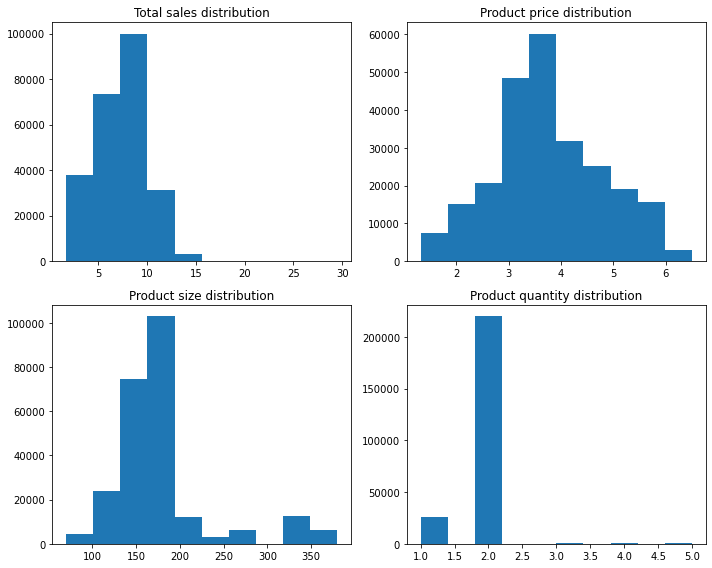

In [43]:
# Create lists of numerical variables and their names
num_col = ['tot_sales', 'prod_price', 'prod_size', 'prod_qty']
num_name = ['Total sales', 'Product price', 'Product size', 'Product quantity']

# Loop through 4 graphs
fig, axes = plt.subplots(2,2, figsize=(10,8))
for i,ax in enumerate(axes.flatten()):
    trans[num_col[i]].plot.hist(title=(num_name[i] + ' distribution'),
                                ax=ax)
    ax.set_ylabel(None)   
plt.tight_layout()

It's worth mentioning that these data are from observations per transation per product. To get the distribution of data per transaction, we need to aggregate these data by transaction id.

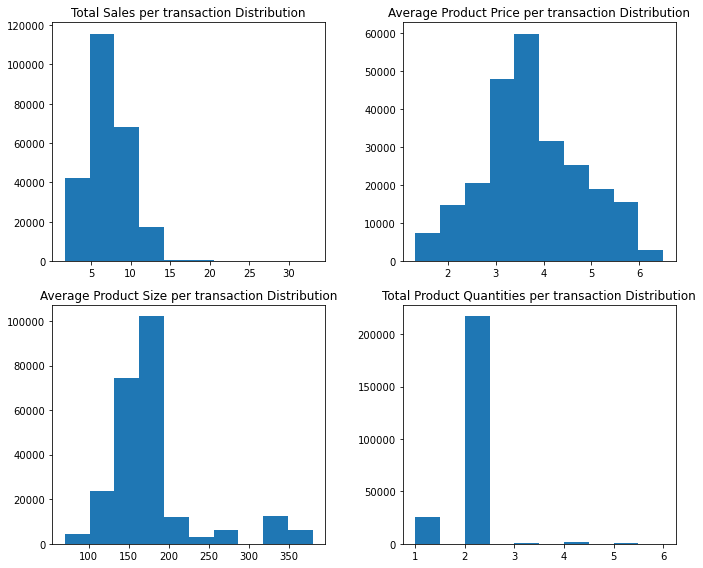

In [44]:
# Draw four agrregated graphs separately
fig, axes = plt.subplots(2,2, figsize=(10,8))
trans.pivot_table(index='txn_id',
                  values='tot_sales',
                  aggfunc='sum').plot.hist(ax=axes[0,0],
                                           title='Total Sales per transaction Distribution',
                                           legend=None)
trans.pivot_table(index='txn_id',
                  values='prod_price',
                  aggfunc='mean').plot.hist(ax=axes[0,1],
                                            title='Average Product Price per transaction Distribution',
                                            legend=None)
trans.pivot_table(index='txn_id',
                  values='prod_size',
                  aggfunc='mean').plot.hist(ax=axes[1,0],
                                            title='Average Product Size per transaction Distribution',
                                            legend=None)
trans.pivot_table(index='txn_id',
                  values='prod_qty',
                  aggfunc='sum').plot.hist(ax=axes[1,1],
                                           title='Total Product Quantities per transaction Distribution',
                                           legend=None)
axes[0,0].set_ylabel(None)
axes[0,1].set_ylabel(None)
axes[1,0].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout()

We can see that:
- Most customers spend around 10 dollars, more or less, for a transaction.
- A bag of chips has a cost, on average in each transaction, from 3 to 4 dollars.
- In each transaction, a bag of chips has a size, on average, of 150g to 200g.
- Most customers buy two bags of chips per transaction.

Next, we will analyse total sales by different variables.

### Total Sales and number of Transactions

**Total sales and transactions over time**

I would like to know the total sales and number of transactions over time.

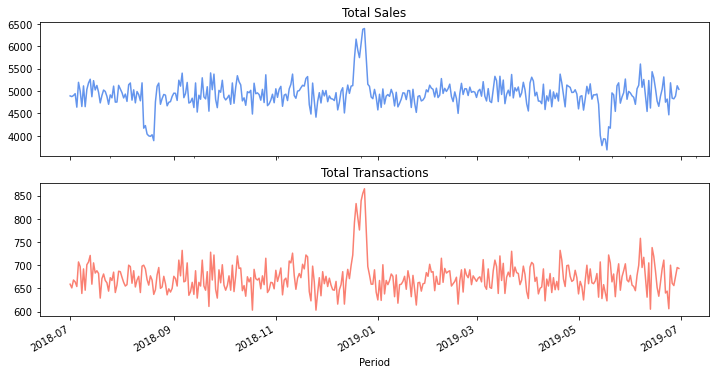

In [45]:
fig, axes = plt.subplots(2,1, figsize=(12,6))

# Total sales by date
trans.pivot_table(index='date',
                  values='tot_sales',
                  aggfunc='sum').plot(ax=axes[0],
                                      title='Total Sales',
                                      legend=None,
                                      color='cornflowerblue')

# Total transactions by date
trans.pivot_table(index='date',
                  values='txn_id',
                  aggfunc=lambda x: x.nunique()).plot(ax=axes[1],
                                                      title='Total Transactions',
                                                      legend=None,
                                                      color='salmon',
                                                      sharex=True)

plt.xlabel('Period')
plt.show()

We can easily see that the peak for both sales and transactions was in Christmas season, from mid to the end of December 2018. There were two low sales periods: August 2018 and May 2019 even though the number of transcations respectively did not change much. My guess is that these are sale/discount periods offered by the company. But we should go check with the marketing team for more information.

Next, let's see if there's any buying trend by weekdays.

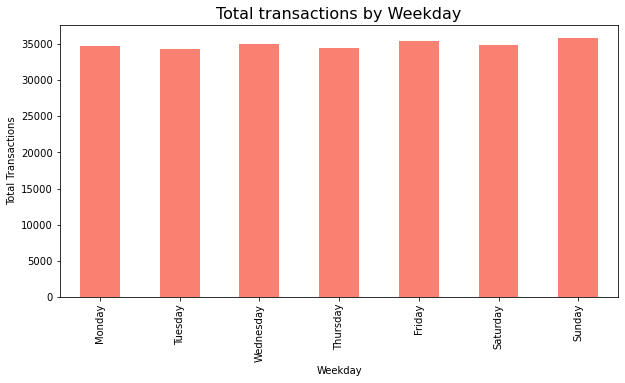

In [46]:
# Draw a count plot of total transactions by weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                 'Friday', 'Saturday', 'Sunday']

trans_by_weekday = trans.pivot_table(index='weekday',
                                     values='txn_id',
                                     aggfunc=lambda x: x.nunique())

trans_by_weekday.loc[weekday_order].plot.bar(figsize=(10,5),
                                             color='salmon',
                                             legend=None)

plt.title('Total transactions by Weekday', fontsize=16)
plt.xlabel('Weekday')
plt.ylabel('Total Transactions')
plt.show()

Friday and Sunday have the highest number of transactions. However, the difference in number of transactions among weekdays is not significant.

**Total Sales by Store Number**

Now, let's see which stores have the highest sales over time.

In [47]:
# Aggregate total sales by store number and time
sales_by_store = trans.pivot_table(index=['year', 'month'], columns=['store_nbr'],
                                   values='tot_sales', aggfunc='sum')

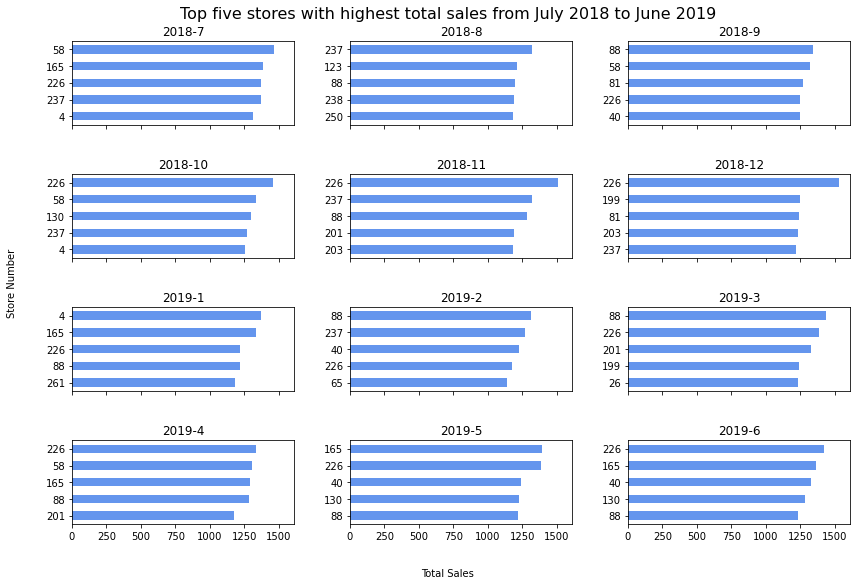

In [48]:
# Draw graphs of top five stores over time
period = sales_by_store.index.tolist()
fig, axes = plt.subplots(4, 3, figsize=(12,8), sharex=True)
fig.suptitle('Top five stores with highest total sales from July 2018 to June 2019', fontsize=16)
fig.text(0.5, -0.01, 'Total Sales', ha='center')
fig.text(-0.01, 0.5, 'Store Number', va='center', rotation='vertical')

for i, ax in enumerate(axes.flatten()):
    sales_by_store.iloc[i].nlargest(5).sort_values().plot.barh( \
        title=(str(period[i][0]) + '-' + str(period[i][1])),
        color='cornflowerblue', ax=ax)
    ax.set_ylabel(None)
       
plt.tight_layout(pad=3)

Store 226 had the highest sales in 6 months and in 2 consecutive rows: Oct 2018 to Dec 2018 and Apr 2019 to Jun 2019. We can also see that the top five has repeated store numbers over time.

**Total Sales by brand**

Which brand had the highest sales?

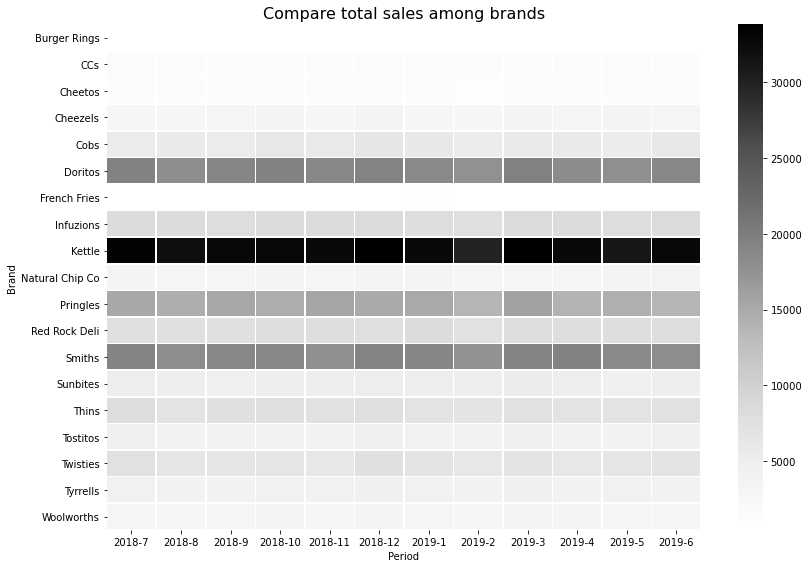

In [49]:
# Draw heatmap of total sales by brand and time
sales_by_brand = trans.pivot_table(columns=['year', 'month'],
                                   index='brand',
                                   values='tot_sales',
                                   aggfunc='sum')

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(sales_by_brand,
            cmap='Greys',
            linewidths=.5,
            ax=ax)

plt.title('Compare total sales among brands', fontsize=16)
plt.xlabel('Period')
plt.ylabel('Brand')
plt.tight_layout()

Kettle is the dominant brand over time. Next we have Doritos, Smiths, and Pringles. Let's see which flavours of each these brands are the most popular.

### Popular flavours

In [50]:
# Loop over four brands
for i in ['Kettle', 'Smiths', 'Doritos', 'Pringles']:
    print('Most popular flavour of ' + str(i) +
          f": \t{trans[trans['brand'] == i]['prod_name'].value_counts().idxmax()}")

Most popular flavour of Kettle: 	Kettle Mozzarella Basil & Pesto
Most popular flavour of Smiths: 	Smiths Crinkle Chips Original Big Bag
Most popular flavour of Doritos: 	Doritos Corn Chips Cheese Supreme
Most popular flavour of Pringles: 	Pringles BBQ


Use word cloud to see which flavours are popular of all products.

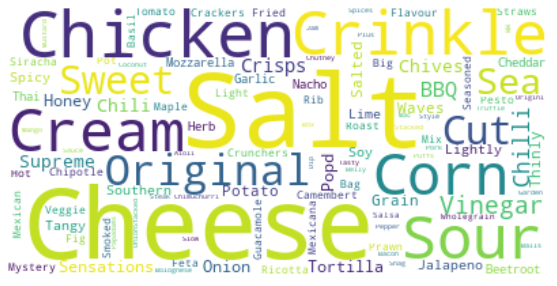

In [51]:
from wordcloud import WordCloud, STOPWORDS
text = ' '.join(trans['prod_name'])
stopwords = list(STOPWORDS) + ' '.join(trans['brand'].unique()).split() + ['Chips']
wc = WordCloud(stopwords=stopwords,
               collocations=False,
               background_color='white',
               random_state=0).generate(text=text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

We have salt, cheese, and chicken are the most popular.<br>That's it for the transaction data. Let's move to the customer data.

## Customer Data - Data Cleaning

In [52]:
# Read in the dataset
customer = pd.read_csv('QVI_purchase_behaviour.csv')

In [53]:
# View the first 5 rows
customer.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [54]:
# Change column headers to lower cases and rename columns
customer.columns = map(str.lower, customer.columns)
customer = customer.rename(columns={'lylty_card_nbr':'card_nbr','premium_customer':'customer_type'})

In [55]:
# Check general info
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   card_nbr       72637 non-null  int64 
 1   lifestage      72637 non-null  object
 2   customer_type  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [56]:
# Change card_nbr to category
customer['card_nbr'] = customer['card_nbr'].astype(str)

In [57]:
# Check other info
customer.describe()

,card_nbr,lifestage,customer_type
count,72637,72637,72637
unique,72637,7,3
top,124289,RETIREES,Mainstream
freq,1,14805,29245


In [58]:
print('Customer lifestage:')
customer['lifestage'].unique().tolist()

Customer lifestage:


['YOUNG SINGLES/COUPLES',
 'YOUNG FAMILIES',
 'OLDER SINGLES/COUPLES',
 'MIDAGE SINGLES/COUPLES',
 'NEW FAMILIES',
 'OLDER FAMILIES',
 'RETIREES']

In [59]:
print('Customer type:')
customer['customer_type'].unique().tolist()

Customer type:


['Premium', 'Mainstream', 'Budget']

In [60]:
customer.to_csv('customer', index=False)

## Customer Data -  Visualization

Let's see how many customers we have in each segment.

In [61]:
print('Number of customers by segments:')
customer['customer_type'].value_counts()

Number of customers by segments:


Mainstream    29245
Budget        24470
Premium       18922
Name: customer_type, dtype: int64

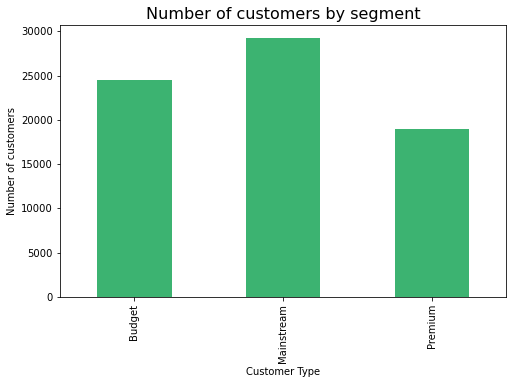

In [62]:
# Count plot of number of customers in each segment
order = ['Budget', 'Mainstream', 'Premium']
customer['customer_type'].value_counts().loc[order].plot.bar(figsize=(8,5),
                                                             color='mediumseagreen')
plt.title('Number of customers by segment', fontsize=16)
plt.xlabel('Customer Type')
plt.ylabel('Number of customers')
plt.show()

Most customers are mainstream. I'm also interested in customers' lifestage in each segment. 

In [63]:
col_order = ['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES', 'OLDER SINGLES/COUPLES',
             'NEW FAMILIES', 'YOUNG FAMILIES', 'OLDER FAMILIES', 'RETIREES']

# Create a function to make stacked bar plot with percentage
def draw_bar(data):
    """ Get data and return a stacked barchart with percentages """
    
    #Count number of unique customers by segment and lifestage
    pivot_df = data.pivot_table(index='customer_type',
                                values='card_nbr',
                                columns='lifestage',
                                aggfunc=lambda x: x.nunique()).reindex(columns=col_order)
    
    #Convert to percentage
    percentage_dist = 100*pivot_df.divide(pivot_df.sum(axis=1), axis=0)
    #Stacked bar plot
    ax = percentage_dist.plot(kind='barh',
                              stacked=True,
                              figsize=(13,8),
                              colormap='Set2')

    #Insert percentage labels to the graph
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x + width / 2,
                y + height / 2,
                '{:.2f}'.format(width),
                horizontalalignment='center',
                verticalalignment='center')
        
    #Complete the graph
    plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
    plt.title('Customer lifestage proportion by Customer type', fontsize=16)
    plt.xlabel('Percentage of each lifestage')
    plt.ylabel('Customer Type')
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

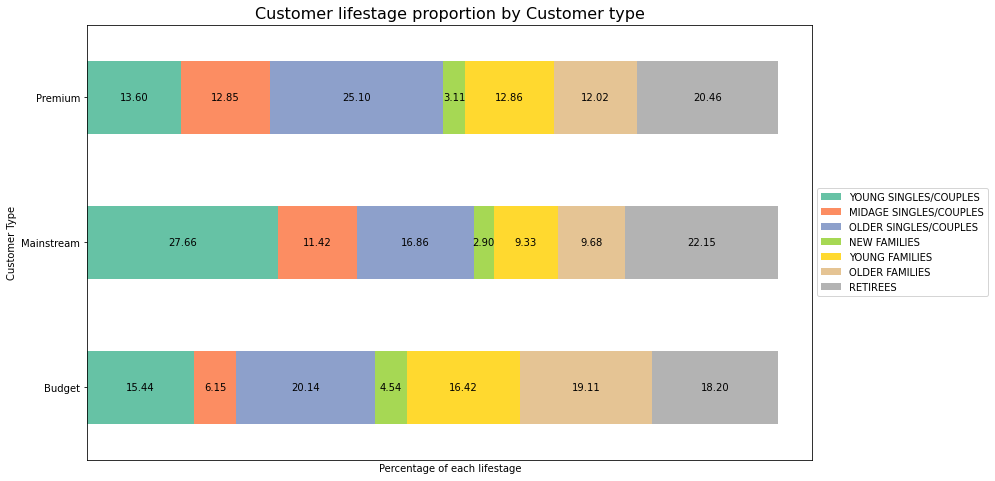

In [64]:
# Apply draw_bar function on customer data
draw_bar(customer)

- Most customers of Budget segment are older singles/couples and older families.
- Most customers of Mainstream segement are young single/couples and retirees.
- Most customers of Premium segment are older single/couples and retirees.

## Customer Segment Analysis

Now, we merge transaction and customer data by card_nbr.

In [65]:
# Check number of records
print(f'There are {len(trans)} rows in transaction dataset.')
print(f'There are {len(customer)} rows in customer dataset.')

There are 246407 rows in transaction dataset.
There are 72637 rows in customer dataset.


In [66]:
# Merge transaction data and customer data
df = pd.merge(customer, trans, on='card_nbr', how='right')

In [67]:
# Check general info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246407 entries, 0 to 246406
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   card_nbr       246407 non-null  object        
 1   lifestage      246407 non-null  object        
 2   customer_type  246407 non-null  object        
 3   date           246407 non-null  datetime64[ns]
 4   store_nbr      246407 non-null  object        
 5   txn_id         246407 non-null  object        
 6   prod_nbr       246407 non-null  object        
 7   prod_name      246407 non-null  object        
 8   prod_qty       246407 non-null  int64         
 9   tot_sales      246407 non-null  float64       
 10  prod_price     246407 non-null  float64       
 11  year           246407 non-null  int64         
 12  month          246407 non-null  int64         
 13  weekday        246407 non-null  object        
 14  prod_size      246407 non-null  int64         
 15  

Great! No missing data.

In [68]:
# Check number of customers
print(f"There are {df['card_nbr'].nunique()} customers.")

There are 71251 customers.


That means there are some customers who did not have any tranasactions during this period. Let's see total sales of each segment and lifestage.

In [69]:
# Aggregate total sales by segment and lifestage
sales_by_segment = df.pivot_table(index='customer_type',
                                  columns='lifestage',
                                  values='tot_sales',
                                  aggfunc='sum').reindex(columns=col_order)

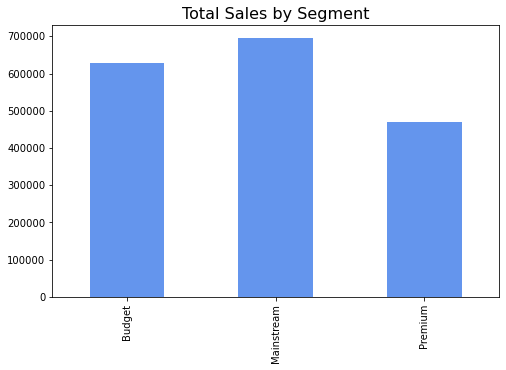

In [70]:
# Total sales by segment
sales_by_segment.sum(axis=1).plot.bar(figsize=(8,5),
                                      color='cornflowerblue',
                                      legend=None)

plt.title('Total Sales by Segment', fontsize=16)
plt.xlabel(None)
plt.show()

Mainstream segment brings in the most sales. Let's see how different this number is among lifestages.<br>
Before doing so, because we have a different number of customers in the merged data, let's check the proportion of customer lifestages in each segment again.

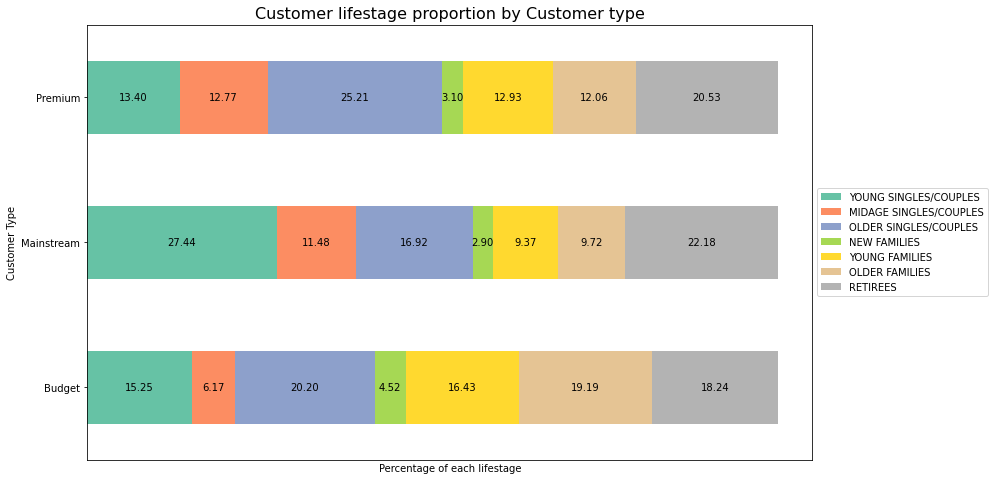

In [71]:
# Apply draw_bar function on the merged data
draw_bar(df)

We still have:
- Most customers of Budget segment are older singles/couples and older families.
- Most customers of Mainstream segement are young single/couples and retirees.
- Most customers of Premium segment are older single/couples and retirees.

Let's plot total sales by segment and lifestage.

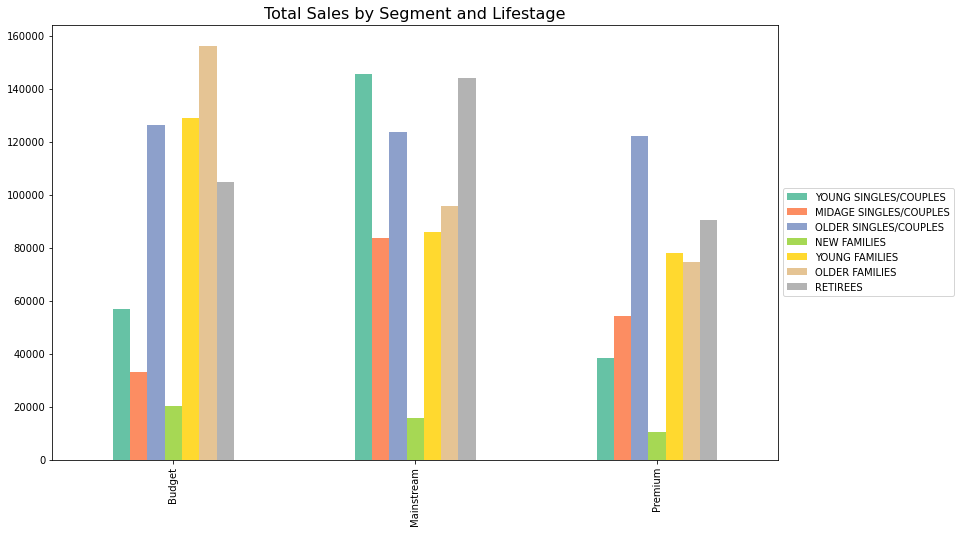

In [72]:
# Total sales by segment and lifestage
sales_by_segment.plot(kind='bar',
                      figsize=(13,8),
                      colormap='Set2')

plt.legend(bbox_to_anchor=(1,0.5), loc='center left')
plt.title('Total Sales by Segment and Lifestage', fontsize=16)
plt.xlabel(None)
plt.show()

- In Budget segment, most sales come from older families.
- In Mainstream segment, most sales come from young singles/couples and retirees.
- In Premium segment, most sales come from older singles/couples.

For Mainstream and Premium segments, the practice of there being more customers of a certain lifestage may have led to more sales. However, this seems not to be the case for Budget segment. Why do Budget - older families have significantly higher sales than other groups in the same segment, especially older singles/couples?<br>
Let's see in average if customers in different lifestages buy the same product quantity/price.

In [73]:
# Get number of unique customers by type and lifstage
num_customers = df[['card_nbr', 'lifestage', 'customer_type']].groupby(  \
                ['customer_type', 'lifestage']).nunique()['card_nbr'].reset_index()

# Get total quantity, sales, size by customer type and lifestage
df['tot_size'] = df['prod_qty']*df['prod_size']
values = df[['prod_qty', 'tot_sales', 'tot_size', 'lifestage', 'customer_type']].groupby(  \
         ['customer_type', 'lifestage']).sum().reset_index()

# Merge the two datasets above and comput the average quatity, price, and size per customer
df1 = pd.merge(num_customers, values, on=['customer_type', 'lifestage'])
df1['avg_qty'] = df1['prod_qty']/df1['card_nbr']
df1['avg_price'] = df1['tot_sales']/df1['prod_qty']
df1['avg_size'] = df1['tot_size']/df1['prod_qty']

# Print out data
df1[['customer_type', 'lifestage', 'avg_qty', 'avg_price', 'avg_size']]

,customer_type,lifestage,avg_qty,avg_price,avg_size
0,Budget,MIDAGE SINGLES/COUPLES,6.016880,3.729121,173.884076
1,Budget,NEW FAMILIES,4.797235,3.914938,174.607877
2,Budget,OLDER FAMILIES,9.111328,3.726149,175.253233
3,Budget,OLDER SINGLES/COUPLES,6.749227,3.867907,175.205977
4,Budget,RETIREES,6.119178,3.913521,176.341169
5,Budget,YOUNG FAMILIES,8.742777,3.739130,175.203890
6,Budget,YOUNG SINGLES/COUPLES,4.240645,3.665108,173.337391
7,Mainstream,MIDAGE SINGLES/COUPLES,6.410264,3.975799,177.650765
8,Mainstream,NEW FAMILIES,4.847172,3.916187,175.590616
9,Mainstream,OLDER FAMILIES,9.256723,3.714407,174.861874


Use these data to make pointplots.

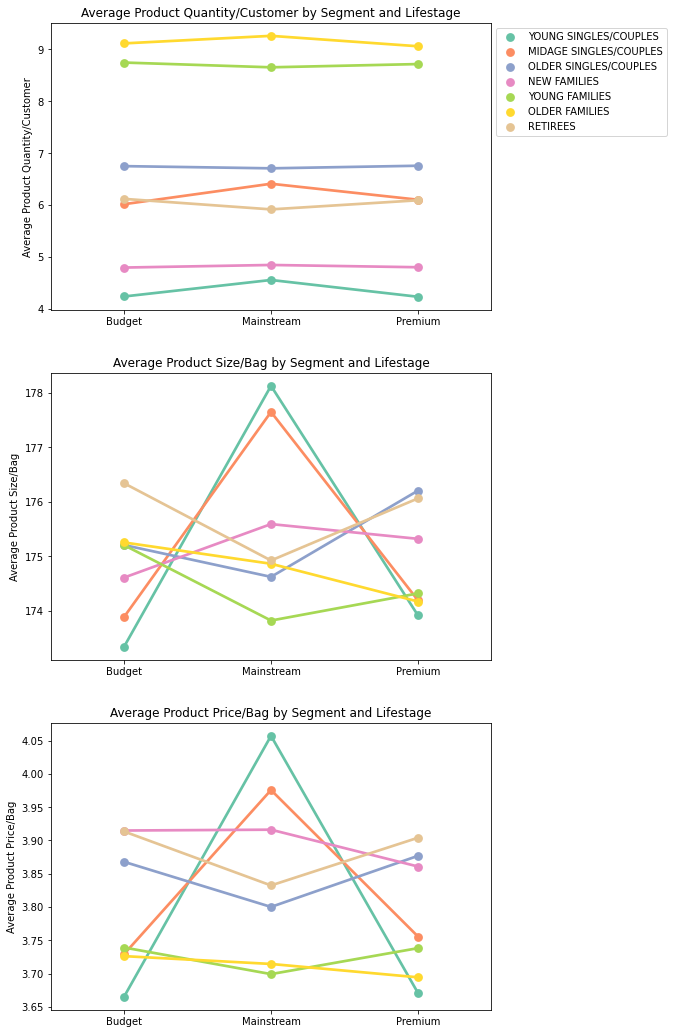

In [74]:
#Separate pointplots of average product quantity and price by customer type and lifestage
fig, axes = plt.subplots(3,1, figsize=(10,15))
sns.pointplot(ax=axes[0],
              x='customer_type',
              y='avg_qty',
              hue='lifestage',
              hue_order=col_order,
              order=order,
              palette='Set2',
              data=df1)
axes[0].legend(bbox_to_anchor=(1,1), loc='upper left')
axes[0].set_title('Average Product Quantity/Customer by Segment and Lifestage')
axes[0].set_ylabel('Average Product Quantity/Customer')
axes[0].set_xlabel(None)

sns.pointplot(ax=axes[1],
              x='customer_type',
              y='avg_size',
              hue='lifestage',
              hue_order=col_order,
              order=order,
              palette='Set2',
              data=df1)
axes[1].get_legend().remove()
axes[1].set_title('Average Product Size/Bag by Segment and Lifestage')
axes[1].set_ylabel('Average Product Size/Bag')
axes[1].set_xlabel(None)

sns.pointplot(ax=axes[2],
              x='customer_type',
              y='avg_price',
              hue='lifestage',
              hue_order=col_order,
              order=order,
              palette='Set2',
              data=df1)
axes[2].get_legend().remove()
axes[2].set_title('Average Product Price/Bag by Segment and Lifestage')
axes[2].set_ylabel('Average Product Price/Bag')
axes[2].set_xlabel(None)

plt.tight_layout(pad=3)

Older families and young families have a tendency to buy more bags per customer. Look at the Budget segment, because there are more older families and these customers buy more bags per customer than other groups, their total sales become the highest in this segment even though they pick cheaper products.

Most of customers of Mainstream segment are young singles/couples, and they buy the most expensive (and the biggest) products; therefore, this group contributes the most sales. Besides young singles/couples, midage singles/couples have the same buying behavior in this segment.

Finally, it is reasonable for older singles/couples and retirees to have the most sales in Premium segment. These two groups have the most number of customers in this segment and on average, they pay the highest price for the largest size of products.

To examine which group brings in the most sales, we should look at their buying behaviors rather than their number of customers. Among these groups, Mainstream young signles/couples and midage singles/couples buy higher product price and size, on average. We can pick these two groups as our target. But first, let's perform a t-test to see if there is significant difference of average product price between young and midage singles/couples in Mainstream segment and those in Buget and Premium ones. 

### Student's t-test

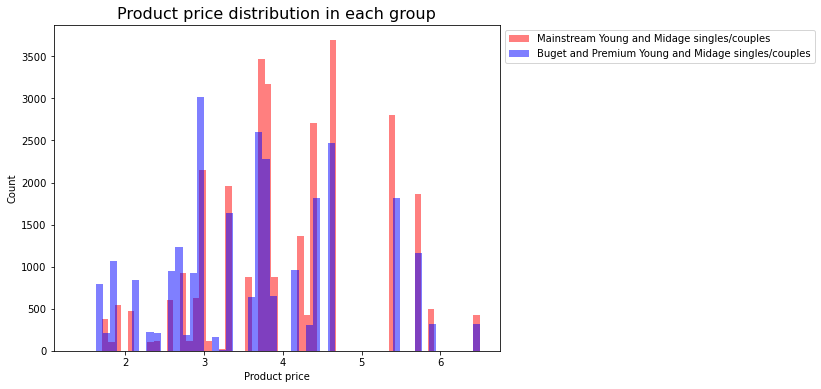

In [75]:
# Get two value arrays from two groups
mainstream = df[(df['customer_type'] == 'Mainstream') &
                ((df['lifestage'] == 'YOUNG SINGLES/COUPLES') |
                (df['lifestage'] == 'MIDAGE SINGLES/COUPLES'))]['prod_price']
others = df[(df['customer_type'] != 'Mainstream') &
            ((df['lifestage'] == 'YOUNG SINGLES/COUPLES') |
            (df['lifestage'] == 'MIDAGE SINGLES/COUPLES'))]['prod_price']

# Plot their distribution
plt.figure(figsize=(8,6))
plt.hist(mainstream, color=[1,0,0,0.5], bins='fd',
         label='Mainstream Young and Midage singles/couples')
plt.hist(others, color=[0,0,1,0.5], bins='fd',
         label='Buget and Premium Young and Midage singles/couples')
plt.xlabel('Product price')
plt.ylabel('Count')
plt.title('Product price distribution in each group', fontsize=16)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

In [76]:
# Print out mean values
print(f'Mean product price of Mainstream young and midage singles/couples (a): {round(mainstream.mean()*100)/100}')
print(f'Mean product price of Buget, Premium young and midage singles/couples (b): {round(others.mean()*100)/100}\n')

# Perform a two sample independent t-test (unpaired, having the same population variances)  
dfreedom = len(mainstream) + len(others) - 2
t_val, p_val = ttest_ind(mainstream, others, equal_var=True)

# Print out t statistic and left-tail p-value
print('Our hypotheses:\n\t\tH0: mu(a) = mu(b)\n\t\tHa: mu(a) # mu(b)\nResult:\n')
print(f't-value({dfreedom})\t{round(t_val*100)/100}\np-value\t\t{p_val}\n')
print(f'For a right-tailed t distribution at at a significance level of 0.05, we have:\nt-statistic({dfreedom}) = {round(t.ppf(0.95, dfreedom)*100)/100}')

Mean product price of Mainstream young and midage singles/couples (a): 4.02
Mean product price of Buget, Premium young and midage singles/couples (b): 3.68

Our hypotheses:
		H0: mu(a) = mu(b)
		Ha: mu(a) # mu(b)
Result:

t-value(57195)	38.11
p-value		0.0

For a right-tailed t distribution at at a significance level of 0.05, we have:
t-statistic(57195) = 1.64


We can reject the null hypothesis in favor of the alternative hypothesis. Mainstream young and midage singles/couples buy a significantly higher price per product than their Buget and Premium counterparts.

## Target Segment - Basket Analysis

In this part, I would like to find buying behavior of Mainstream young singles/couples. We will employ Apriori Algorithm to perform this.

In [77]:
# Apriori algorithm and association rule for basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [78]:
# Extract target data
data = df[(df['customer_type'] == 'Mainstream') &
          (df['lifestage'] == 'YOUNG SINGLES/COUPLES')][['txn_id', 'brand', 'prod_qty']].reset_index(drop=True)
# Convert to dummies
basket = data.groupby(['txn_id', 'brand'])['prod_qty'].sum().unstack().fillna(0)
# Make sure there are only ones and zeroes
basket[basket > 1] = 1
basket.head()

brand,Burger Rings,CCs,Cheetos,Cheezels,Cobs,Doritos,French Fries,Infuzions,Kettle,Natural Chip Co,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
txn_id,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100014,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100015,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100017,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# Get the frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.123142,(Doritos)
1,0.064678,(Infuzions)
2,0.199058,(Kettle)
3,0.119880,(Pringles)
4,0.050179,(Red Rock Deli)
5,0.102895,(Smiths)
6,0.060380,(Thins)


In [80]:
# Create a function to run Apriori with support and lift metrics
def basket(col, segment, lifestage, support, metric, mmin):
    """ Return Apriori report of a certain customer segment
    
    Keyword arguments:
    col -- the category of interest
    segment -- the segment of interest
    lifestage -- the lifestage of intesrest
    support -- the support value in the apriori algorithm
    metric -- the metric in the association rule
    mmin -- the minimum threshold in the association rule
    
    """
    # Extract target data
    data = df[(df['customer_type'] == segment) &
              (df['lifestage'] == lifestage)][['txn_id', col, 'prod_qty']].reset_index(drop=True)
    
    # Convert to dummies
    basket = data.groupby(['txn_id', col])['prod_qty'].sum().unstack().fillna(0)
    basket[basket > 1] = 1 #Make sure there are only ones and zeroes
    
    # Get the frequent itemsets
    frequent_itemsets = apriori(basket, min_support=support, use_colnames=True)
    
    # Print out result and table of combination if available
    print(f"There are {len(basket[basket.sum(axis=1) > 1])} (out of {data['txn_id'].nunique()}) transactions")
    print(f'that have more than one '+ col + '\n')
    print(f'There are maximum {basket.sum(axis=1).max()} ' + col + 's per transaction\n')
    print(f'There are {len(frequent_itemsets)} ' + col + 's that are likely to be bought')
    print('in at least ' + str(support*100) + '% of total transactions')
    if len(frequent_itemsets) == 0:
        pass
    else:
        print(f"\n{frequent_itemsets.sort_values(['support'], ascending=False).reset_index(drop=True)}\n")
        rules = association_rules(frequent_itemsets, metric=metric, min_threshold=mmin)
        if len(rules) == 0:
            print('But these ' + col + 's are not likely to be bought together')
        else:
            print(col + f's that are likely to be bought together\n{rules}')

In [81]:
# Print out number of unique transactions, brands, and product names in the target dataset
print('Number of unique transactions, brands, and product names:')
df[(df['customer_type'] == 'Mainstream') &
   (df['lifestage'] == 'YOUNG SINGLES/COUPLES')][['txn_id', 'brand', 'prod_name']].nunique()

Number of unique transactions, brands, and product names:


txn_id       19311
brand           19
prod_name      106
dtype: int64

We can set support metric for brand itemsets as 1/19 (0.05) and for product name itemsets as 1/106 (0.01)

In [82]:
# Apply basket function on brands
basket('brand', 'Mainstream', 'YOUNG SINGLES/COUPLES', 0.05, 'lift', 0.7)

There are 55 (out of 19311) transactions
that have more than one brand

There are maximum 3.0 brands per transaction

There are 7 brands that are likely to be bought
in at least 5.0% of total transactions

    support         itemsets
0  0.199058         (Kettle)
1  0.123142        (Doritos)
2  0.119880       (Pringles)
3  0.102895         (Smiths)
4  0.064678      (Infuzions)
5  0.060380          (Thins)
6  0.050179  (Red Rock Deli)

But these brands are not likely to be bought together


There is no combination among brands when a customer in this group makes a transaction.

In [83]:
# Apply basket function on product names
basket('prod_name', 'Mainstream', 'YOUNG SINGLES/COUPLES', 0.01, 'lift', 0.7)

There are 58 (out of 19311) transactions
that have more than one prod_name

There are maximum 3.0 prod_names per transaction

There are 53 prod_names that are likely to be bought
in at least 1.0% of total transactions

     support                                        itemsets
0   0.017192               (Kettle Mozzarella Basil & Pesto)
1   0.016882             (Doritos Corn Chips Cheese Supreme)
2   0.016726         (Smiths Crinkle Chips Original Big Bag)
3   0.016726  (Kettle Tortilla Chips Honey & Jalapeno Chili)
4   0.016467              (Tyrrells Crisps Cheddar & Chives)
5   0.016312                               (Twisties Cheese)
6   0.016260           (Smiths Crinkle Chips Salt & Vinegar)
7   0.016105                      (Pringles Mystery Flavour)
8   0.015898             (Sunbites Grain Waves Sweet Chilli)
9   0.015846         (Infuzions Thai Sweet Chili Potato Mix)
10  0.015846            (Kettle Sweet Chilli And Sour Cream)
11  0.015846               (Pringles Southern Fri

Same here, there is no combination among products.

Another point worth examining is whether or not our target is more likely to buy from one brand compared to other groups.

In [84]:
# Create a function to run Apriori and compare results between target and other groups
def compare(col, segment, lifestage, mmin):
    """ Return a table that compares support measures
    between the target and others.
    
    Key arguments:
    col -- the category of interest
    segment -- the segment of interest
    lifestage -- the lifestage of interest
    mmin -- the support value in the apriori algorithm
    
    """
    # Extract data
    target_df = df[(df['customer_type'] == segment) &
                   (df['lifestage'] == lifestage)][['txn_id', col, 'prod_qty']].reset_index(drop=True)
    others_df = df[(df['customer_type'] != segment) &
                   (df['lifestage'] != lifestage)][['txn_id', col, 'prod_qty']].reset_index(drop=True)
    
    # Convert values into dummies
    target_basket = target_df.groupby(['txn_id', col])['prod_qty'].sum().unstack().fillna(0)
    others_basket = others_df.groupby(['txn_id', col])['prod_qty'].sum().unstack().fillna(0)
    
    # Make sure there are only ones and zeroes
    target_basket[target_basket > 1] = 1
    others_basket[others_basket > 1] = 1

    # Get the frequent itemsets
    target_itemsets = apriori(target_basket, min_support=mmin, use_colnames=True).set_index(['itemsets'])
    others_itemsets = apriori(others_basket, min_support=mmin, use_colnames=True).set_index(['itemsets'])
    
    # Join these two itemsets and return result
    compare = target_itemsets.join(others_itemsets, lsuffix='_target', rsuffix='_others', how='outer').reset_index()
    compare['affinity'] = compare['support_target']/compare['support_others']
    
    return compare.sort_values(['affinity'], ascending=False).reset_index(drop=True)

In [85]:
# Apply compare function on brands
compare('brand', 'Mainstream', 'YOUNG SINGLES/COUPLES', 0.001)

,itemsets,support_target,support_others,affinity
0,(Tyrrells),0.032054,0.025859,1.239599
1,(Twisties),0.046606,0.037962,1.227685
2,(Doritos),0.123142,0.101453,1.213791
3,(Kettle),0.199058,0.167328,1.189621
4,(Pringles),0.119880,0.101445,1.181720
5,(Cobs),0.044741,0.038696,1.156222
6,(Tostitos),0.028740,0.025514,1.126461
7,(Infuzions),0.064678,0.057890,1.117258
8,(Thins),0.060380,0.057582,1.048597
9,(Cheezels),0.017917,0.019076,0.939232


Affinity column lets us know how greater or lesser support metrics of itemsets in the target group are, comparing to those in other groups, for example:
- Mainstream young singles/couples are 24% more likely to buy from Tyrrells compared to other groups
- But they are 52% less likely to buy from Burger Rings compared to other groups

Since our target has a tendency to buy big bags, let's see which size is the most preferable.

In [86]:
# Apply compare function on product sizes
compare('prod_size', 'Mainstream', 'YOUNG SINGLES/COUPLES', 0.001)

,itemsets,support_target,support_others,affinity
0,(270),0.032106,0.025066,1.280867
1,(380),0.032417,0.025859,1.253617
2,(330),0.061882,0.051145,1.209937
3,(210),0.029828,0.025088,1.188922
4,(134),0.119880,0.101445,1.181720
5,(110),0.106157,0.090215,1.176711
6,(135),0.015017,0.013058,1.150072
7,(250),0.014500,0.012911,1.123040
8,(170),0.081456,0.080835,1.007688
9,(150),0.167728,0.176452,0.950560


They are 28% more likely to buy 270g bags of chips compared to other groups. We also have 330g and 380g are the most largest sizes. Which products have these sizes?

In [87]:
# Print out product names that have size of 270g or above
df[['prod_size', 'prod_name']].groupby('prod_size').\
agg(lambda x: '; '.join(set(x))).reset_index().nlargest(3, 'prod_size')

,prod_size,prod_name
19,380,Smiths Crinkle Chips Original Big Bag; Doritos Corn Chips Supreme
18,330,Cheezels Cheese; Smiths Crinkle Chips Salt & Vinegar; Smiths Crinkle Original; Doritos Cheese Supreme
17,270,Twisties Cheese; Twisties Chicken


Only Twisties has 270g bags.<br>
To make it clearer, let's make another comparison to see which products they are likely to buy more than others.

In [88]:
# Apply compare function on product names
compare('prod_name', 'Mainstream', 'YOUNG SINGLES/COUPLES', 0.01)

,itemsets,support_target,support_others,affinity
0,(Twisties Cheese),0.016312,0.012471,1.308038
1,(Smiths Crinkle Chips Original Big Bag),0.016726,0.012940,1.292568
2,(Pringles Mystery Flavour),0.016105,0.012507,1.287638
3,(Doritos Corn Chips Cheese Supreme),0.016882,0.013124,1.286332
4,(Kettle Sensations BBQ Maple),0.015794,0.012324,1.281599
5,(Pringles Southern Fried Chicken),0.015846,0.012397,1.278188
6,(Doritos Cheese Supreme),0.015691,0.012360,1.269415
7,(Kettle Mozzarella Basil & Pesto),0.017192,0.013550,1.268848
8,(Kettle Tortilla Chips Honey & Jalapeno Chili),0.016726,0.013190,1.268112
9,(Doritos Corn Chips Original),0.015742,0.012441,1.265339


Our target is a huge fan of Twisties Cheese! And among 106 products, they are more likely to buy more than half of them compared to other groups.

## Conclusion
At this point, we can conclude that:
- The peak season is December, before Christmas.
- Store 226 has the highest monthly sales most of the time.
- The most favourite brand is Kettle. The most favourite falvours are salt (or sea salt), cheese, and chicken.
- Most customers are young singles/couples, older singles/couples, and retirees.
- For Budget segment, because there are more older families and these customers buy more bags per product than other groups, their total sales become the highest in this segment even though they pick cheaper products.
- For Mainstream and Premium segments, the practice of there being more customers of a certain lifestage may have led to more sales.
- Comparing to other groups, Mainstream - young singles/couples are more likely to buy from Tyrrells, more likely to choose Twisties Cheese 270g, and less likely to buy from Burger Rings, Woolworths, CCs, and some other brands. There is no indication that they buy more than one brand or product per transaction.